# Non-Unitary Operators for the Non-Hermitian Skin Effect

Paper to be replicated: https://arxiv.org/pdf/2311.10143

Addition Resources Consulted:
- https://link.aps.org/pdf/10.1103/PRXQuantum.2.010342
- https://medium.com/mdr-inc/time-evolution-operators-be2968493b86 (note there are some notable errors)
- 

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [138]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector

from tqdm.notebook import tqdm

from numpy import sin, cos
import numpy as np
from scipy.linalg import expm, sqrtm

from scipy.optimize import differential_evolution, dual_annealing

from itertools import product

import random

import json





In [4]:
# service = QiskitRuntimeService()
BACKEND = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=BACKEND, optimization_level=0)
estimator = Estimator(backend=BACKEND)
sampler = Sampler(backend=BACKEND)

## I. Hatano-Nelson Model

Note $\hat{X}^+ = \frac{\hat{X} + i \hat{Y}}{2}$ and $\hat{X}^- = \frac{\hat{X} - i \hat{Y}}{2}$

In [5]:
X_gate = np.array([[0, 1], 
                   [1, 0]])

Y_gate = np.array([[0, -1j],
                   [1j, 0]])

I_gate = np.array([[1, 0], 
                   [0, 1]])

X_plus = 0.5 * (X_gate + 1j * Y_gate)
X_minus = 0.5 * (X_gate - 1j * Y_gate)

In [10]:
# Helper function, generates U_j_nonH
def get_U_j_nonH(J, gamma, index, N, timestep):
    product_1 = np.kron(X_plus, X_minus)
    product_2 = np.kron(X_minus, X_plus)
    exponent = 1j * timestep * ( (J - gamma) * product_1 + (J + gamma) * product_2)
    
    if index == 0:
        U_j_nonH = np.kron(np.eye(2 ** (N-2)), expm(exponent))
    if index == N - 2:
        U_j_nonH = np.kron(expm(exponent), np.eye(2 ** (N-2)))
    else: 
        U_j_nonH = np.kron(np.kron(np.eye(2 ** (N - 2 - index)), expm(exponent)), np.eye(2 ** (index)))
    return U_j_nonH
    


# Helper function, generates R_HN
def get_R_HN(J, gamma, N, timestep):
    res_even = np.eye(2 ** N)
    res_odd = np.eye(2 ** N)
    for i in range(N - 1):
        if i % 2 == 0:
            res_even = np.matmul(res_even, get_U_j_nonH(J, gamma, i, N, timestep))
        else:
            res_odd = np.matmul(res_odd, get_U_j_nonH(J, gamma, i, N, timestep))
    return np.matmul(res_even, res_odd)

# Generates U_HN 
def get_U_HN(J, gamma, N, timestep):
    R_HN = get_R_HN(J, gamma, N, timestep)

    A, sig, Bh = np.linalg.svd(R_HN)
    eigval, _ = np.linalg.eig(np.matmul(R_HN.conj().T, R_HN))
    u_square_inverse = max(eigval)
    u_square = 1/u_square_inverse 
    C = np.matmul(np.matmul(A, sqrtm(np.eye(2 ** N) - u_square * np.diag(np.square(sig)))), Bh)

    u_R_HN = np.sqrt(u_square) * R_HN
    W = np.concatenate((np.concatenate((u_R_HN, C), axis=0), np.concatenate((np.eye(2 ** N), np.eye(2 ** N)), axis=0)), axis=1)
    U_HN, _ = np.linalg.qr(W)
    return U_HN

In [11]:
def projection(N):
    projector = np.array([[1.0, 0.0], [0.0, 0.0]])
    
    return np.kron(projector, np.eye(2 ** (N-1)))

projection(3)

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [12]:
total_time = 1.8
nb_timesteps = 10
timestep_duration = total_time/nb_timesteps

# First Attempt Using Gates
Note: This attempt missed out on implementing the projection between each trotter step, hence the non-unitary case where $gamma \neq 0.0$ gives the wrong figure.

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0, 'T')

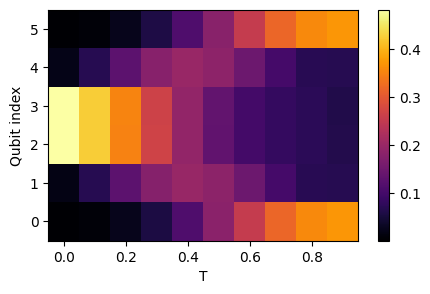

In [13]:
# For gamma = 0.0 case 
# (Original Implementation using individual UnitaryGates, but missed out projection between each trotter step)
N = 6

# Generate the unitary
matrix = get_U_HN(2, 0.0, N, 0.1)
gate = UnitaryGate(matrix)

# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    qc = QuantumCircuit(N+1)
    qc.h(N//2 - 1)
    qc.cx(N//2 - 1, N//2)
    
    gate = UnitaryGate(np.linalg.matrix_power(matrix, n_steps))
    qc.append(gate, [i for i in range(N+1)])
    
    qc.measure_all()
    circuits.append(qc)

# Execute measurements for paper's Fig 3a
magnetization=[]
res_list = []
for circ in tqdm(circuits):
    pubs = [(circ)]
    job = sampler.run(pubs, shots=160000)
    results = job.result()
    res = results[0].data.meas.get_counts()

    counts_left = 0
    row = [0 for _ in range(N)]
    for key, value in res.items():
        if key[0] == "0":
            counts_left += value

            for i in range(1, N+1):
                if key[i] == '1':
                    row[i-1] += value
    magnetization.append([x/counts_left for x in row][::-1]) #the output for qiskit is qNqN-1...q1q0

magnetization=np.array(magnetization)

fig = plt.figure(figsize=(10/2,6/2), facecolor='white')
im = plt.pcolormesh([0.1 * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')



In [14]:
# For gamma = 0.5 case 
# (Original Implementation using individual UnitaryGates, but missed out projection between each trotter step)
N = 6

# Generate the unitary
matrix = get_U_HN(2, 0.5, N, 0.1)
gate = UnitaryGate(matrix)

# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    qc = QuantumCircuit(N+1)
    qc.h(N//2 - 1)
    qc.cx(N//2 - 1, N//2)
    
    gate = UnitaryGate(np.linalg.matrix_power(matrix, n_steps))
    qc.append(gate, [i for i in range(N+1)])
    
    qc.measure_all()
    circuits.append(qc)

# Execute measurements for paper's Fig 3a
magnetization=[]
res_list = []
for circ in tqdm(circuits):
    pubs = [(circ)]
    job = sampler.run(pubs, shots=160000)
    results = job.result()
    res = results[0].data.meas.get_counts()

    counts_left = 0
    row = [0 for _ in range(N)]
    for key, value in res.items():
        if key[0] == "0":
            counts_left += value

            for i in range(1, N+1):
                if key[i] == '1':
                    row[i-1] += value
    magnetization.append([x/counts_left for x in row][::-1]) #the output for qiskit is qNqN-1...q1q0

magnetization=np.array(magnetization)

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0, 'T')

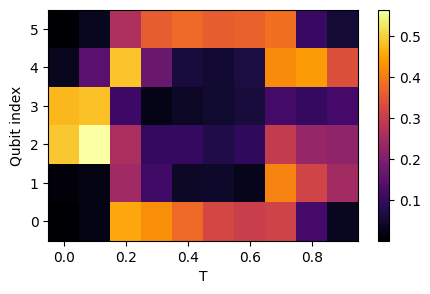

In [15]:
fig = plt.figure(figsize=(10/2,6/2), facecolor='white')
im = plt.pcolormesh([0.1 * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

# Second Attempt: Mathematical implementation of Fig 3a
Note: Qiskit was not used

(6, 10)


Text(0.5, 0, 'T')

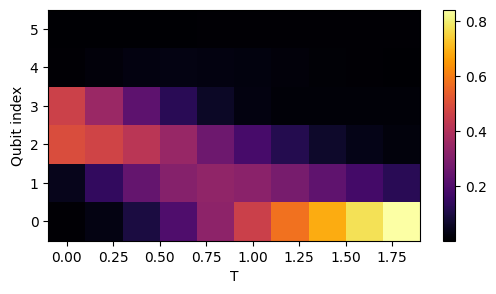

In [16]:
# For gamma = 0.5 case 
# (Full matrices and state vector based, no qiskit)
N = 6
nb_timesteps = 10
timestep_duration = 0.2
gamma = 0.5
J = 1

# Generate the unitary
matrix = get_U_HN(J, gamma , N, timestep_duration)
projection_matrix = projection(N+1)

# create the initial state vector (|↓↓↑↓↓↓⟩+|↓↓↓↑↓↓⟩)/ 2
initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)

magnetization=[]
for n_steps in range(1, nb_timesteps + 1):

    # for each time step, apply the matrix n_steps times onto the initial vector
    state_vector = np.matmul(np.linalg.matrix_power(matrix @ projection_matrix, n_steps), initial_vector).T[0]
    state_dict = {}
    for i in range(2 ** (N+1)):

        # allocate the relevant probabilities to each state
        state_dict[bin(i)[2:].zfill(N+1)] = np.abs(state_vector[i]) ** 2

   
    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in state_dict.items():

        # key[0] is the ancillary qubit
        if key[0] == '0':
            prob += value
            for i in range(1, N + 1):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i] += value

    magnetization += [[x/prob for x in row]]

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

# Third Attempt: Adapting the Mathematical Representation to Qiskit
Note: the `Statevector` Class was used, however sampler was not used as far as I am aware.

The first attempt follows the method detailed in the paper. Since a second non-unitary operation (the projection between each trotter step) was necessary, I adopted using the `Statevector` class which came with an `evolve` method which can take non-unitary operators. However, I am not sure why we cannot use this directly with the non-unitary HN operator.


  0%|          | 0/10 [00:00<?, ?it/s]

(6, 10)


Text(0.5, 0, 'T')

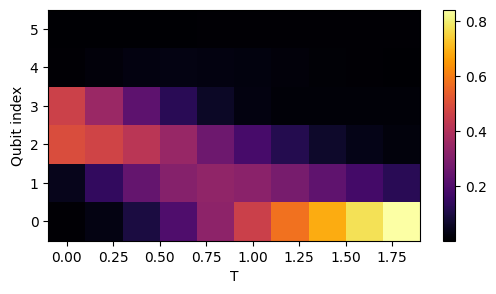

In [17]:
# For gamma = 0.5 case 
# Adapting the math representation to Qiskit
N = 6
J = 1
gamma = 0.5
timestep_duration = 0.2

# Generate the unitary
matrix = get_U_HN(J, gamma, N, timestep_duration)
projection_matrix = projection(N+1)
gate = Operator(matrix)
projector = Operator(projection_matrix)

initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)


magnetization=[]
# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    state = Statevector(initial_vector)
    
    for _ in range(n_steps):
        state = state.evolve(gate)
        state = state.evolve(projector)
    
    # qc.measure_all()
    # circuits.append(qc)
    circuits.append(state)

# Execute measurements for paper's Fig 3a
density=[]
res_list = []
for circ in tqdm(circuits):
    # pubs = [(circ)]
    # job = sampler.run(pubs, shots=160000)
    # results = job.result()
    # res = results[0].data.meas.get_counts()
    probs = circ.probabilities()
    state_dict = {}
    for i in range(2 ** (N+1)):

        # allocate the relevant probabilities to each state
        state_dict[bin(i)[2:].zfill(N+1)] = np.abs(probs[i])

    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in state_dict.items():

        # key[0] is the ancillary qubit
        if key[0] == '0':
            prob += value
            for i in range(1, N + 1):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i] += value

    magnetization += [[x/prob for x in row]]

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

  0%|          | 0/10 [00:00<?, ?it/s]

(6, 10)


Text(0.5, 0, 'T')

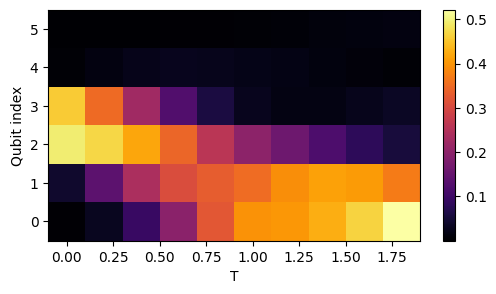

In [177]:
# For gamma = 0.5 case 
# Using R_HN directly
N = 6
J = 1
gamma = 0.5
timestep_duration = 0.2

# Generate the unitary
matrix = get_R_HN(J, gamma, N, timestep_duration)
projection_matrix = projection(N+1)
gate = Operator(matrix)
projector = Operator(projection_matrix)

initial_vector = np.zeros((2**(N), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)


magnetization=[]
# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    state = Statevector(initial_vector)
    
    for _ in range(n_steps):
        state = state.evolve(gate)
        #state = state.evolve(projector)
    
    # qc.measure_all()
    # circuits.append(qc)
    circuits.append(state)

# Execute measurements for paper's Fig 3a
density=[]
res_list = []
for circ in tqdm(circuits):
    # pubs = [(circ)]
    # job = sampler.run(pubs, shots=160000)
    # results = job.result()
    # res = results[0].data.meas.get_counts()
    probs = circ.probabilities()
    state_dict = {}
    for i in range(2 ** (N)):

        # allocate the relevant probabilities to each state
        state_dict[bin(i)[2:].zfill(N)] = np.abs(probs[i])

    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in state_dict.items():

        # key[0] is the ancillary qubit
        if True: #key[0] == '0':
            prob += value
            for i in range(0, N):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i - 1] += value

    magnetization += [[x/prob for x in row]]

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

# Fourth Attempt: Integrating Sampler (and hence adapting for execution on quantum computers)
This is similar to attempt 3, except the `Statevectors` are now made into circuits and `Sampler` can thus be used on them (as far as I am aware). However, my original question in attempt 3 remains, hence there is a second circuit under this attempt (also directly using `R_HN`)

  0%|          | 0/10 [00:00<?, ?it/s]

(6, 10)


Text(0.5, 0, 'T')

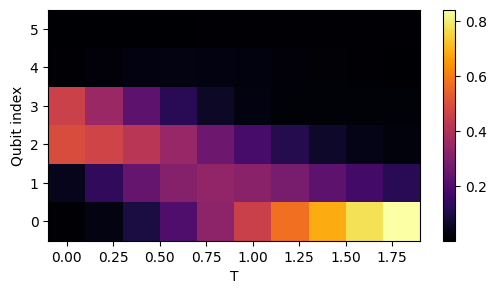

In [184]:
# For gamma = 0.5 case 
# Adapting the math representation to Qiskit
# Using Sampler
N = 6
J = 1
gamma = 0.5
timestep_duration = 0.2

# Generate the unitary
matrix = get_U_HN(J, gamma, N, timestep_duration)
projection_matrix = projection(N+1)
gate = Operator(matrix)
projector = Operator(projection_matrix)

initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)


magnetization=[]
# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    qc = QuantumCircuit(N+1)
    state = Statevector(initial_vector)
    
    for _ in range(n_steps):
        state = state.evolve(gate)
        state = state.evolve(projector)
    
    qc.initialize(state, range(N+1), normalize=True)
    qc.measure_all()
    circuits.append(qc)

# Execute measurements for paper's Fig 3a
magnetization=[]
res_list = []
for circ in tqdm(circuits):
    pubs = [(circ)]
    job = sampler.run(pubs, shots=160000)
    results = job.result()
    res = results[0].data.meas.get_counts()

    counts_left = 0
    row = [0 for _ in range(N)]
    for key, value in res.items():
        if key[0] == "0":
            counts_left += value

            for i in range(1, N+1):
                if key[i] == '0':
                    row[i-1] += value
    magnetization.append([x/counts_left for x in row][::-1]) #the output for qiskit is qNqN-1...q1q0

magnetization=np.array(magnetization)

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

  0%|          | 0/10 [00:00<?, ?it/s]

(6, 10)


Text(0.5, 0, 'T')

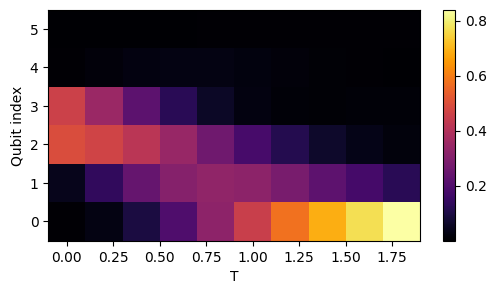

In [186]:
# For gamma = 0.5 case 
# Adapting the math representation to Qiskit
# Using Sampler
N = 6
J = 1
gamma = 0.5
timestep_duration = 0.2

# Generate the unitary
matrix = get_R_HN(J, gamma, N, timestep_duration)
projection_matrix = projection(N+1)
gate = Operator(matrix)
projector = Operator(projection_matrix)

initial_vector = np.zeros((2**(N), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)


magnetization=[]
# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    qc = QuantumCircuit(N)
    state = Statevector(initial_vector)
    
    for _ in range(n_steps):
        state = state.evolve(gate)
        # state = state.evolve(projector)
    
    qc.initialize(state, range(N), normalize=True)
    qc.measure_all()
    circuits.append(qc)

# Execute measurements for paper's Fig 3a
magnetization=[]
res_list = []
for circ in tqdm(circuits):
    pubs = [(circ)]
    job = sampler.run(pubs, shots=160000)
    results = job.result()
    res = results[0].data.meas.get_counts()

    counts_left = 0
    row = [0 for _ in range(N)]
    for key, value in res.items():
        if True: #key[0] == "0":
            counts_left += value

            for i in range(0, N):
                if key[i] == '0':
                    row[i] += value
    magnetization.append([x/counts_left for x in row][::-1]) #the output for qiskit is qNqN-1...q1q0

magnetization=np.array(magnetization)

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

# Attempt 6: Using VQA -- adapting from attempt 2

In [79]:
# For gamma = 0.5 case 
# (Full matrices and state vector based, no qiskit)
N = 6
nb_timesteps = 10
timestep_duration = 0.2
gamma = 0.5
J = 1

# Generate the unitary
matrix = get_U_HN(J, gamma , N, timestep_duration)
projection_matrix = projection(N+1)

# create the initial state vector (|↓↓↑↓↓↓⟩+|↓↓↓↑↓↓⟩)/ 2
initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)

states_all_circuits={}
for n_steps in range(1, nb_timesteps + 1):

    # for each time step, apply the matrix n_steps times onto the initial vector
    state_vector = np.matmul(np.linalg.matrix_power(projection_matrix @ matrix, n_steps), initial_vector).T[0]
    state_dict = {}
    for i in range(2 ** (N+1)):
 
        # allocate the relevant quasi-probabilities to each state
        # state_dict[bin(i)[2:].zfill(N+1)] = np.abs(state_vector[i]) ** 2
        state_dict[bin(i)[2:].zfill(N+1)] = state_vector[i]
    
    states_all_circuits[n_steps] = state_dict



'''
    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in state_dict.items():

        prob += value
        for i in range(1, N + 1):

            # if the other qubits have a result of 0, then add the probabilities to that qubit
            if key[i] == '0':
                row[N - i] += value

    states += [[x/prob for x in row]]

states = np.array(states)

print(states.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), states.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

'''

"\n    # create a new row to add to magnetization array\n    row = [0 for _ in range(N)]\n    prob = 0\n    for key, value in state_dict.items():\n\n        prob += value\n        for i in range(1, N + 1):\n\n            # if the other qubits have a result of 0, then add the probabilities to that qubit\n            if key[i] == '0':\n                row[N - i] += value\n\n    states += [[x/prob for x in row]]\n\nstates = np.array(states)\n\nprint(states.T.shape)\nfig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')\nim = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), states.T, cmap='inferno')\nfig.colorbar(im)\nplt.ylabel('Qubit index')\nplt.xlabel('T')\n\n"

In [68]:
def variational_circuit(params):
    qc = QuantumCircuit(N+1)
    stepper = 0
    layers = 8

    # initial
    for qubit in range(N+1):
        qc.u(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2], qubit)
        stepper += 1
    
    for layer in range(layers):
        # CX gates
        qc.cx(0, 1)
        qc.cx(2, 3)
        qc.cx(4, 5)

        # first set of U3 gates
        while qubit in range(N):
            qc.u(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2], qubit)
            stepper += 1
        
        # CX gates
        qc.cx(0, 1)
        qc.cx(2, 3)
        qc.cx(4, 5)

        # CX gates
        qc.cx(1, 2)
        qc.cx(3, 4)
        qc.cx(5, 6)

        # first set of U3 gates
        while qubit in range(N):
            qc.u(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2], qubit+1)
            stepper += 1
        
        # CX gates
        qc.cx(1, 2)
        qc.cx(3, 4)
        qc.cx(5, 6)

    qc.measure_all()

    return qc




In [47]:
def calculate_results(params):

    # initialization of the sampler
    sampler = Sampler()
    
    # Sampler runs a job on the Bell circuit
    job = sampler.run(circuits=[variational_circuit(params)], parameter_values=[[]], parameters=[[]])
    job_result = job.result()
    return job_result.quasi_dists[0].binary_probabilities()

{'0000000': 1.854145032e-07,
 '0000001': 6.01622501809e-05,
 '0000010': 3.919117605e-07,
 '0000011': 0.0001271653132625,
 '0000100': 1.91293573e-08,
 '0000101': 6.2069857436e-06,
 '0000110': 4.04338385e-08,
 '0000111': 1.31197434292e-05,
 '0001000': 3.25560558e-08,
 '0001001': 1.05636050175e-05,
 '0001010': 6.88139328e-08,
 '0001011': 2.23283560237e-05,
 '0001100': 3.3588334e-09,
 '0001101': 1.0898552755e-06,
 '0001110': 7.0995865e-09,
 '0001111': 2.3036337088e-06,
 '0010000': 0.0001844564961396,
 '0010001': 0.0598514014567525,
 '0010010': 0.0003898868151435,
 '0010011': 0.1265082704281085,
 '0010100': 1.9030518945e-05,
 '0010101': 0.0061749152409814,
 '0010110': 4.02249233684e-05,
 '0010111': 0.0130519558132852,
 '0011000': 3.23878439099e-05,
 '0011001': 0.0105090245599277,
 '0011010': 6.84583821967e-05,
 '0011011': 0.0222129889794414,
 '0011100': 3.3414788311e-06,
 '0011101': 0.00108422416758,
 '0011110': 7.0629040809e-06,
 '0011111': 0.0022917312019171,
 '0100000': 1.352276227e-07,


In [146]:
def cost_function(params, n_steps):
    results = calculate_results(params)
    sum = 0
    for key in results:
        sum += np.conj(results[key]) * states_all_circuits[n_steps][key]

    return np.abs(1 - sum) * 100

In [131]:
cost_function(np.ones((((N+1) + (N * 2 * 8)) * 3)), 8)

1.0000586993277734

In [116]:
#params0 = np.ones((((N+1) + (N * 2 * 8)) * 3))
#params0 = np.([np.pi for _ in range(((N+1) + (N * 2 * 8)) * 3)])
randoms = np.random.rand(((N+1) + (N * 2 * 8)) * 3)
params0 = np.array([i * np.pi if i % 3 == 0 else i * 2 * np.pi for i in randoms])
bounds = tuple([(0.0, np.pi) if i % 3 == 0 else (0.0, 2 * np.pi) for i in range(((N+1) + (N * 2 * 8)) * 3)])
print(len(params0))



309


In [142]:
bounds

((0.0, 3.141592653589793),
 (0.0, 6.283185307179586),
 (0.0, 6.283185307179586),
 (0.0, 3.141592653589793),
 (0.0, 6.283185307179586),
 (0.0, 6.283185307179586),
 (0.0, 3.141592653589793),
 (0.0, 6.283185307179586),
 (0.0, 6.283185307179586),
 (0.0, 3.141592653589793),
 (0.0, 6.283185307179586),
 (0.0, 6.283185307179586),
 (0.0, 3.141592653589793),
 (0.0, 6.283185307179586),
 (0.0, 6.283185307179586),
 (0.0, 3.141592653589793),
 (0.0, 6.283185307179586),
 (0.0, 6.283185307179586),
 (0.0, 3.141592653589793),
 (0.0, 6.283185307179586),
 (0.0, 6.283185307179586),
 (0.0, 3.141592653589793),
 (0.0, 6.283185307179586),
 (0.0, 6.283185307179586),
 (0.0, 3.141592653589793),
 (0.0, 6.283185307179586),
 (0.0, 6.283185307179586),
 (0.0, 3.141592653589793),
 (0.0, 6.283185307179586),
 (0.0, 6.283185307179586),
 (0.0, 3.141592653589793),
 (0.0, 6.283185307179586),
 (0.0, 6.283185307179586),
 (0.0, 3.141592653589793),
 (0.0, 6.283185307179586),
 (0.0, 6.283185307179586),
 (0.0, 3.141592653589793),
 

In [147]:
# to do: find 10 sets of parameters for the 10 circuits (10 timesteps)
# cost function: 1 - complex conjugate of quasi-prob of circuit * quasi-prob of mathematical results (can probably use np.dot)
res = dual_annealing(cost_function, bounds, args=(8,))

In [144]:
res.x

array([1.52325045e-02, 4.64759364e+00, 3.49853364e+00, 4.61591772e-02,
       2.62920018e+00, 5.71294761e+00, 1.67806702e-01, 1.30392187e+00,
       3.13486314e+00, 2.39378963e-03, 4.26297716e+00, 5.48202212e+00,
       7.35285709e-02, 3.61516049e+00, 5.49580334e+00, 4.20737070e-01,
       4.74753094e+00, 1.09019920e+00, 2.16438305e+00, 1.35364948e+00,
       2.69407566e+00, 2.40880658e+00, 3.91454212e-01, 5.12672731e+00,
       6.10673872e-01, 3.74689069e+00, 5.54941898e+00, 8.31739934e-01,
       5.06026649e+00, 5.27118122e+00, 2.90292937e+00, 9.55987916e-01,
       9.28681143e-01, 2.91599371e+00, 1.37906886e+00, 1.09468734e+00,
       4.10892713e-02, 3.15808114e+00, 5.27954785e+00, 9.30225379e-02,
       5.87794065e+00, 3.19488910e-01, 2.95794148e+00, 9.28482074e-01,
       8.08396395e-01, 4.87281493e-01, 2.97682510e+00, 2.72162796e+00,
       2.10195268e+00, 3.86538278e+00, 2.57893902e+00, 1.23263190e-01,
       1.32216133e-01, 5.52749386e-01, 2.29657825e+00, 4.75535446e+00,
      

In [145]:
cost_function(res.x, 8)

1.0

In [119]:
res.x

array([1.38255207, 3.14483026, 3.14147034, 1.07013329, 3.14250783,
       3.14239049, 0.57260169, 3.1427403 , 3.13864251, 0.43050229,
       3.14543821, 3.14207722, 0.40248869, 3.1432647 , 3.1205233 ,
       0.60447823, 3.14081521, 3.14043588, 2.8894874 , 3.14052258,
       3.13549161, 1.64961162, 3.14149933, 3.14072934, 1.57105089,
       3.13649344, 3.12085091, 1.64062677, 3.14080103, 3.15407918,
       1.57958152, 3.14047076, 3.14179612, 1.57324207, 3.14228711,
       3.14232167, 1.58296751, 3.14214136, 3.14744301, 1.56997267,
       3.15682946, 3.14140264, 1.59438248, 3.15041844, 3.14051279,
       1.65729088, 3.14073275, 3.14061859, 1.66508361, 3.14450068,
       3.14274418, 1.56476871, 3.14427381, 3.15331547, 1.56979207,
       3.14262815, 3.13823735, 1.66017607, 3.15013441, 3.14074915,
       1.57098074, 3.14268479, 3.14236522, 1.5715761 , 3.1308815 ,
       3.1435911 , 1.61865564, 3.14054251, 3.12280083, 1.59464989,
       3.15363591, 3.14186828, 1.57788585, 3.13550209, 3.12108

In [107]:
res = minimize(cost_function, params0, args=3, method='trust-constr', bounds=bounds)
res

           message: The maximum number of function evaluations is exceeded.
           success: False
            status: 0
               fun: 0.9995630342765495
                 x: [ 3.228e+00  3.367e+00 ...  2.668e+00  3.689e+00]
               nit: 1000
              nfev: 308760
              njev: 996
              nhev: 0
          cg_niter: 1004
      cg_stop_cond: 4
              grad: [-2.309e-04  0.000e+00 ...  0.000e+00  0.000e+00]
   lagrangian_grad: [-1.896e-04  6.083e-06 ... -1.292e-05  1.498e-05]
            constr: [array([ 3.228e+00,  3.367e+00, ...,  2.668e+00,
                            3.689e+00])]
               jac: [<309x309 sparse matrix of type '<class 'numpy.float64'>'
                    	with 309 stored elements in Compressed Sparse Row format>]
       constr_nfev: [0]
       constr_njev: [0]
       constr_nhev: [0]
                 v: [array([ 4.131e-05,  6.083e-06, ..., -1.292e-05,
                            1.498e-05])]
            method: tr_interior_

In [121]:
params_dict = {}
for n_steps in range(1, nb_timesteps + 1):
    print("Step number: ", n_steps)
    res = minimize(cost_function, params0, args=n_steps, method='trust-constr', bounds=bounds)
    params_dict[n_steps] = res.x


In [125]:
params_dict[2]

array([3.13844687e+00, 3.12194195e+00, 3.14229589e+00, 3.13853743e+00,
       3.11722668e+00, 3.13133255e+00, 3.13844874e+00, 3.14917649e+00,
       3.14931079e+00, 2.97357963e-03, 3.13428174e+00, 3.13874919e+00,
       3.13843859e+00, 3.14924679e+00, 3.15175955e+00, 3.13842961e+00,
       3.14803112e+00, 3.15129234e+00, 3.03962096e-03, 3.16200028e+00,
       3.14912232e+00, 1.56255781e+00, 3.14212906e+00, 3.15165481e+00,
       1.56926631e+00, 3.14882028e+00, 3.15170259e+00, 1.56359399e+00,
       3.15187170e+00, 3.15574022e+00, 1.57269291e+00, 3.14958551e+00,
       3.14043520e+00, 1.56845942e+00, 3.13080140e+00, 3.13752129e+00,
       1.57252661e+00, 3.13835022e+00, 3.13417050e+00, 1.57205252e+00,
       3.13243355e+00, 3.14231003e+00, 1.57078172e+00, 3.13353794e+00,
       3.15079247e+00, 1.56168077e+00, 3.14695660e+00, 3.15252031e+00,
       1.56079761e+00, 3.13386864e+00, 3.13292950e+00, 1.56933940e+00,
       3.13376278e+00, 3.14971810e+00, 1.57291766e+00, 3.13431968e+00,
      

In [132]:
for i in range(1, nb_timesteps+1):
    print(cost_function(params_dict[i], i))
    print(cost_function(np.ones(((N+1) + (N * 2 * 8)) * 3), i))
    print(cost_function(np.zeros(((N+1) + (N * 2 * 8)) * 3), i))

0.9559451155062559
1.0003464798372952
1.0
0.6974523989942258
0.9998182198426212
1.0
0.8793026968312
1.0000613161753344
1.0
0.9162569545778838
1.0000150912288566
1.0
0.8715690632484777
0.9999446161378382
1.0
0.9853319411268976
1.0000699990860842
1.0
0.9046883051083761
0.9999314393118364
1.0
1.0000000148509185
1.0000586993277734
1.0
0.9433140459603733
0.9999542766878677
1.0
1.0000000171365262
1.0000328983940399
1.0


In [126]:
res

{'0000000': 0.0063676348623095,
 '0000001': 0.004022661189023,
 '0000010': 0.0017324068546874,
 '0000011': 0.0010944229637283,
 '0000100': 0.0008239278586752,
 '0000101': 0.0005205045030558,
 '0000110': 0.0002241614509942,
 '0000111': 0.0001416107532056,
 '0001000': 0.0004902610555952,
 '0001001': 0.0003097153281363,
 '0001010': 0.0001333825873601,
 '0001011': 8.42625196116e-05,
 '0001100': 6.34363857952e-05,
 '0001101': 4.00750188458e-05,
 '0001110': 1.72587832004e-05,
 '0001111': 1.09029865643e-05,
 '0010000': 0.0002518742916134,
 '0010001': 0.0001591179392812,
 '0010010': 6.85260318385e-05,
 '0010011': 4.329032909e-05,
 '0010100': 3.25907892384e-05,
 '0010101': 2.05887595353e-05,
 '0010110': 8.8667940133e-06,
 '0010111': 5.6014688216e-06,
 '0011000': 1.93924681226e-05,
 '0011001': 1.22509111409e-05,
 '0011010': 5.276000498e-06,
 '0011011': 3.3330369746e-06,
 '0011100': 2.5092510925e-06,
 '0011101': 1.5851830706e-06,
 '0011110': 6.826779309e-07,
 '0011111': 4.31271905e-07,
 '0100000'

(6, 10)


Text(0.5, 0, 'T')

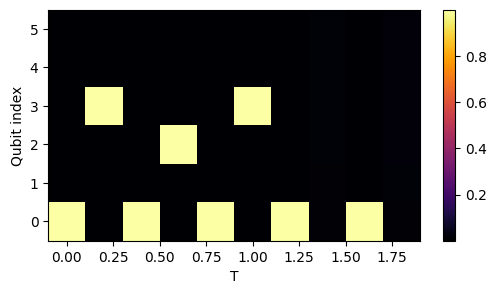

In [122]:
res_all_circuits = []
for n_steps in range(1, nb_timesteps + 1):
    res = calculate_results(params_dict[n_steps])

    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in res.items():

        prob += value
        if key[0] == "0":
            for i in range(1, N + 1):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i] += value

    res_all_circuits += [[x/prob for x in row]]

res_all_circuits = np.array(res_all_circuits)

print(res_all_circuits.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), res_all_circuits.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

# Comparison (Fig S2)

(6, 10)


Text(0.5, 0, 'T')

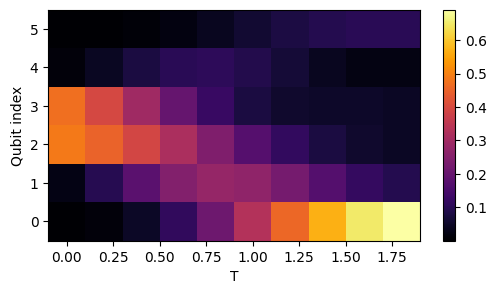

In [39]:
# For gamma = 0.2 case 
# (Full matrices and state vector based, no qiskit)
N = 6
nb_timesteps = 10
timestep_duration = 0.2
gamma = 0.2
J = 1

# Generate the unitary
matrix = get_U_HN(J, gamma , N, timestep_duration)
projection_matrix = projection(N+1)

# create the initial state vector (|↓↓↑↓↓↓⟩+|↓↓↓↑↓↓⟩)/ 2
initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)

magnetization=[]
for n_steps in range(1, nb_timesteps + 1):

    # for each time step, apply the matrix n_steps times onto the initial vector
    state_vector = np.matmul(np.linalg.matrix_power(matrix @ projection_matrix, n_steps), initial_vector).T[0]
    state_dict = {}
    for i in range(2 ** (N+1)):

        # allocate the relevant probabilities to each state
        state_dict[bin(i)[2:].zfill(N+1)] = np.abs(state_vector[i]) ** 2

   
    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in state_dict.items():

        # key[0] is the ancillary qubit
        if key[0] == '0':
            prob += value
            for i in range(1, N + 1):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i] += value

    magnetization += [[x/prob for x in row]]

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

  0%|          | 0/10 [00:00<?, ?it/s]

(6, 10)


Text(0.5, 0, 'T')

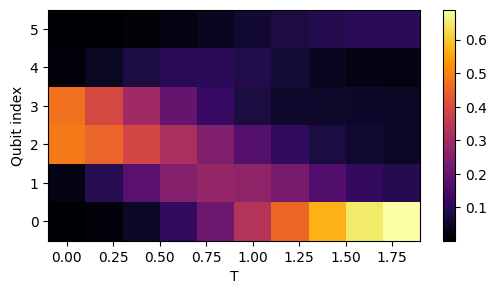

In [38]:
# For gamma = 0.2 case 
# Adapting the math representation to Qiskit
# Using Sampler
N = 6
J = 1
gamma = 0.2
timestep_duration = 0.2

# Generate the unitary
matrix = get_U_HN(J, gamma, N, timestep_duration)
projection_matrix = projection(N+1)
gate = Operator(matrix)
projector = Operator(projection_matrix)

initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)


magnetization=[]
# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    qc = QuantumCircuit(N+1)
    state = Statevector(initial_vector)
    
    for _ in range(n_steps):
        state = state.evolve(gate)
        state = state.evolve(projector)
    
    qc.initialize(state, range(N+1), normalize=True)
    qc.measure_all()
    circuits.append(qc)

# Execute measurements for paper's Fig 3a
magnetization=[]
res_list = []
for circ in tqdm(circuits):
    pubs = [(circ)]
    job = sampler.run(pubs, shots=160000)
    results = job.result()
    res = results[0].data.meas.get_counts()

    counts_left = 0
    row = [0 for _ in range(N)]
    for key, value in res.items():
        if key[0] == "0":
            counts_left += value

            for i in range(1, N+1):
                if key[i] == '0':
                    row[i-1] += value
    magnetization.append([x/counts_left for x in row][::-1]) #the output for qiskit is qNqN-1...q1q0

magnetization=np.array(magnetization)

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

# nH-SSH Model

In [9]:
def get_N_total(N):
    return int(N + N/2)

In [10]:
def unitary(J, timestep):
    product_1 = np.kron(np.kron(X_gate, I_gate), X_gate)
    product_2 = np.kron(np.kron(Y_gate, I_gate), Y_gate)
    exponent = 1j * timestep * ( (J/2) * (product_1 + product_2))
    return expm(exponent)


def get_unitary(J, timestep, N):
    gate = unitary(J, timestep)
    matrix = np.kron(I_gate, I_gate)
    for _ in range(2, get_N_total(N) - 1, 3):
        matrix = np.kron(matrix, gate)
    matrix = np.kron(matrix, I_gate)
    return matrix


def get_all_U_R(J, gamma, N, timestep):
    gate = get_U_HN(J, gamma, 2, timestep)
    matrix = gate
    for _ in range(1, int(N/2)):
        matrix = np.kron(matrix, gate)
    return matrix

def get_all_projection(N):
    projection_matrix = projection(3)
    matrix = projection_matrix
    for _ in range(1, int(N/2)):
        matrix = np.kron(matrix, projection_matrix)
    return matrix


In [11]:
def check_ancillary(N, key):
    total_N = get_N_total(N)
    for i in range(total_N):
        if i % 3 == 0:
            if key[i] != "0":
                return False
    return True


In [16]:
def get_density(J, gamma, N, nb_timesteps, timestep_duration):
    total_N = get_N_total(N)

    # Generate the unitary
    matrix = get_all_U_R(J, gamma , N, timestep_duration)
    projection_matrix = get_all_projection(N)
    unitary_term = get_unitary(J, timestep_duration, N)

    # create the initial state vector (|↓↓↑↓↓↓⟩+|↓↓↓↑↓↓⟩)/ 2
    initial_vector = np.zeros((2**(total_N), 1), dtype=complex)
    binary_1 = "" #011" + "010" + "011
    binary_2 = ""
    for index in range(N):
        if index % 2 == 0:
            binary_1 += "0"
            binary_2 += "0"
        
        if index == N/2 - 1:
            binary_1 += "0"
            binary_2 += "1"
        elif index == N/2:
            binary_1 += "1"
            binary_2 += "0"
        else:
            binary_1 += "1"
            binary_2 += "1"
            
    initial_vector[int(binary_1, 2)] = 1/np.sqrt(2)
    initial_vector[int(binary_2, 2)] = 1/np.sqrt(2)

    magnetization=[]
    for n_steps in range(1, nb_timesteps + 1):

        # for each time step, apply the matrix n_steps times onto the initial vector
        state_vector = np.matmul(np.linalg.matrix_power(np.matmul(unitary_term, np.matmul(projection_matrix, matrix)), n_steps), initial_vector).T[0]
        state_dict = {}
        for i in range(2 ** (total_N)):

            # allocate the relevant probabilities to each state
            state_dict[bin(i)[2:].zfill(total_N)] = np.abs(state_vector[i]) ** 2

    
        # create a new row to add to magnetization array
        row = [0 for _ in range(N)]
        prob = 0
        for key, value in state_dict.items():

            # key[0] is the ancillary qubit
            if check_ancillary(N, key):
                prob += value
                for i in range(total_N):

                    # if the other qubits have a result of 0, then add the probabilities to that qubit
                    if i % 3 != 0:
                        if key[i] == '0':
                            real_index = i // 3 * 2 + i % 3
                            row[N - real_index] += value

        magnetization += [[x/prob for x in row]]
    return np.array(magnetization)

In [13]:

nb_timesteps = 10
timestep_duration = 0.1
gamma = 0.5
J = 2



In [17]:
density_6 = get_density(J, gamma, 6, nb_timesteps, timestep_duration)


In [18]:
density_8 = get_density(J, gamma, 8, nb_timesteps, timestep_duration)


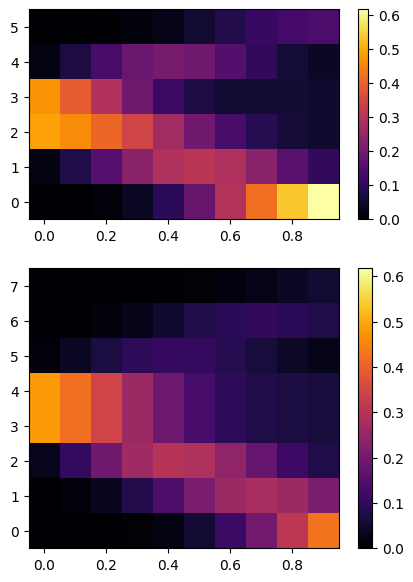

In [34]:
fig, axes = plt.subplots(2, height_ratios=[6, 8], figsize=(10/2, (6 + 8)/2))
plt.inferno()
im_0 = axes[0].pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,6,1), density_6.T, vmin=0, vmax=np.max(density_6))
im_1 = axes[1].pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,8,1), density_8.T, vmin=0, vmax=np.max(density_6))
fig.colorbar(im_0)
fig.colorbar(im_1)

Text(0.5, 0, 'T')

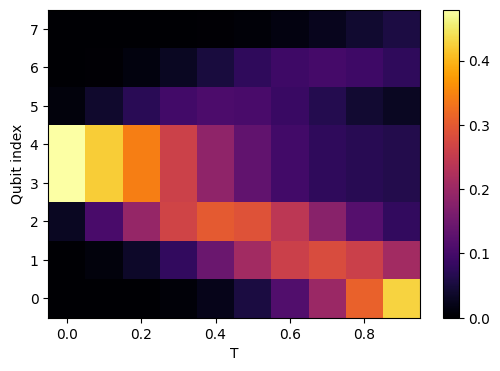

In [41]:
density_8 = magnetization
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), density_8.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')